<a href="https://colab.research.google.com/github/Morty00933/python/blob/main/3_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim
from datetime import datetime, timedelta
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Загрузка данных из DataFrame
df1 = pd.read_excel('weather_from2010_to_2020.xlsx')
df2 = pd.read_excel('weather_from2021_to_2021.xlsx')

# Преобразование даты
df1['Дата'] = pd.to_datetime(df1['Дата'], format='%d.%m.%Y')
df1['Дата'] = df1['Дата'].dt.strftime('%Y%m%d').astype(int)
df2['Дата'] = pd.to_datetime(df2['Дата'], format='%d.%m.%Y')
df2['Дата'] = df2['Дата'].dt.strftime('%Y%m%d').astype(int)

# Выбор нужных столбцов
weather_data = df1[['Дата', 'Максимальная температура', 'Минимальная температура']]
weather_data = weather_data.dropna()
weather_data_test = df2[['Дата', 'Максимальная температура', 'Минимальная температура']]
weather_data_test = weather_data_test.dropna()

print(weather_data)
print(weather_data_test)




          Дата  Максимальная температура  Минимальная температура
0     20100101                       0.0                     -5.6
1     20100102                      -2.2                     -8.0
2     20100103                      -2.0                    -13.0
3     20100104                     -13.1                    -28.0
4     20100105                     -22.6                    -30.0
...        ...                       ...                      ...
3989  20201227                      -3.0                    -11.1
3990  20201228                      -3.0                    -14.0
3991  20201229                     -11.0                    -19.0
3992  20201230                      -8.0                    -15.4
3993  20201231                      -8.0                    -11.0

[3993 rows x 3 columns]
         Дата  Максимальная температура  Минимальная температура
0    20210101                      -7.0                    -13.0
1    20210102                      -7.0              

In [ ]:
# Подготовка данных
data = weather_data[['Максимальная температура', 'Минимальная температура']].values.astype(float)
data_test = weather_data_test[['Максимальная температура', 'Минимальная температура']].values.astype(float)

scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data)
data_normalized_test = scaler.fit_transform(data_test)

# Разделение данных на обучающий и тестовый наборы
train_data, test_data = data_normalized, data_normalized_test


# Функция для создания последовательных данных
def create_sequences(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

look_back = 10  # количество дней для анализа
trainX, trainY = create_sequences(train_data, look_back)
testX, testY = create_sequences(test_data, look_back)

# Преобразование в тензоры PyTorch
trainX = torch.from_numpy(trainX).float()
trainY = torch.from_numpy(trainY).float()
testX = torch.from_numpy(testX).float()
testY = torch.from_numpy(testY).float()

# Создание модели
class WeatherPredictor(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=100, output_size=2):
        super(WeatherPredictor, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Инициализация модели и оптимизатора
model = WeatherPredictor()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Обучение модели
epochs = 150
for i in range(epochs):
    for seq, labels in zip(trainX, trainY):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    # if (i + 1) % 10 == 0:
    print(f"epoch {i+1}, loss {single_loss}")



epoch 10
epoch 20
epoch 30
epoch 40
epoch 50
epoch 60
epoch 70
epoch 80
epoch 90
epoch 100
epoch 110
epoch 120
epoch 130
epoch 140
epoch 150


In [ ]:
# Тестирование модели
model.eval()
test_predictions = []
for seq in testX:
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_predictions.append(model(seq).numpy())

# Обратное преобразование нормализованных данных
test_predictions = scaler.inverse_transform(test_predictions)
test_actual = scaler.inverse_transform(testY)



# Распечатка результатов
for i in range(len(test_predictions)):
    print(f'Предсказание для даты {weather_data_test.iloc[look_back + i, 0]}:')
    print(f'Максимальная температура - Предсказание: {test_predictions[i][0]}, Факт: {test_actual[i][0]}')
    print(f'Минимальная температура - Предсказание: {test_predictions[i][1]}, Факт: {test_actual[i][1]}')
    print('------------------')
    if i>4:
      break

Предсказание для даты 20210111:
Максимальная температура - Предсказание: -11.710479629039764, Факт: -16.40000057518482
Минимальная температура - Предсказание: -23.916126489639282, Факт: -21.999999523162842
------------------
Предсказание для даты 20210112:
Максимальная температура - Предсказание: -9.889140421152113, Факт: -17.400000765919685
Минимальная температура - Предсказание: -24.070260524749756, Факт: -31.00000023841858
------------------
Предсказание для даты 20210113:
Максимальная температура - Предсказание: -15.631936120986937, Факт: -22.099999484419822
Минимальная температура - Предсказание: -30.518430471420288, Факт: -35.0
------------------
Предсказание для даты 20210114:
Максимальная температура - Предсказание: -14.242655742168425, Факт: -10.000000080466268
Минимальная температура - Предсказание: -27.310948848724365, Факт: -25.700000762939453
------------------
Предсказание для даты 20210115:
Максимальная температура - Предсказание: -12.559540367126463, Факт: -7.9999996989

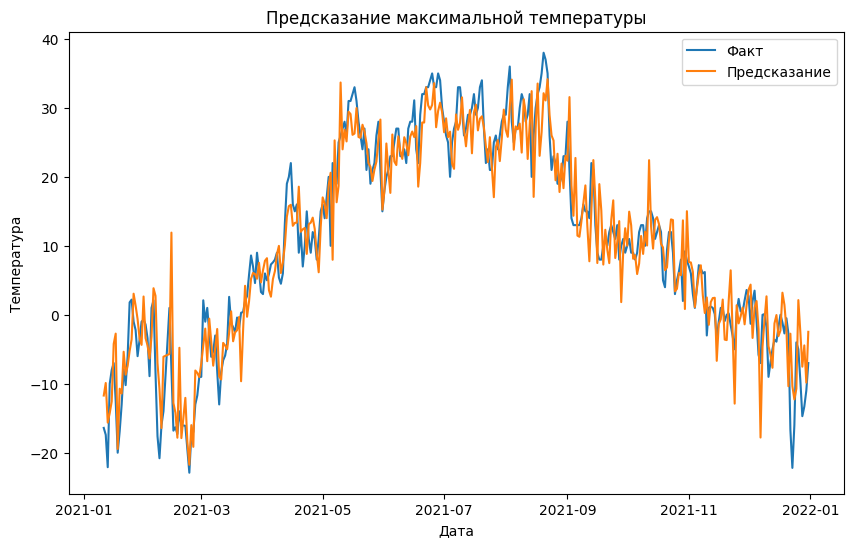

In [ ]:
# Преобразование предсказанных и фактических значений в датафрейм
dates = pd.to_datetime(weather_data_test['Дата'], format='%Y%m%d')[look_back:]
df3 = pd.DataFrame({'Дата': pd.to_datetime(dates), 'Факт': test_actual[:, 0], 'Предсказание': test_predictions[:, 0]})

# Установка даты как индекса
df3.set_index('Дата', inplace=True)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(df3.index, df3['Факт'], label='Факт')
plt.plot(df3.index, df3['Предсказание'], label='Предсказание')
plt.title('Предсказание максимальной температуры')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.legend()
plt.show()

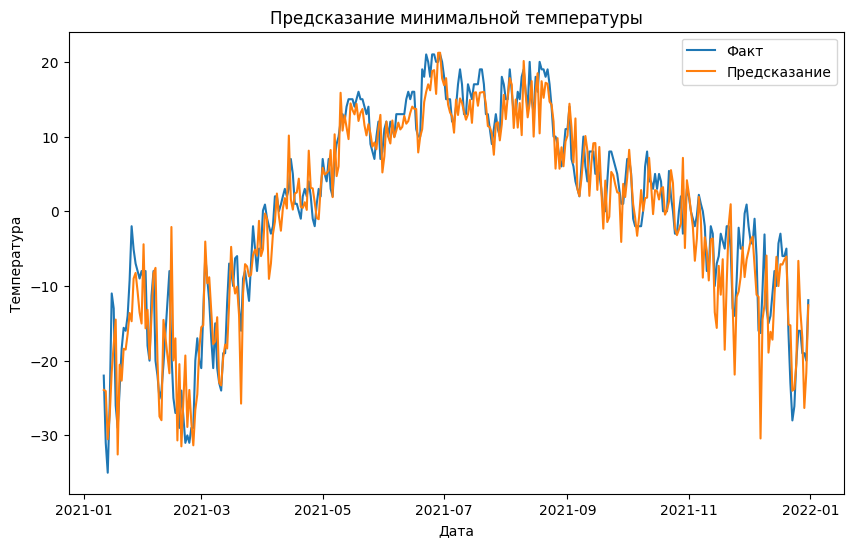

In [ ]:
df4 = pd.DataFrame({'Дата': pd.to_datetime(dates), 'Факт': test_actual[:, 1], 'Предсказание': test_predictions[:, 1]})

# Установка даты как индекса
df4.set_index('Дата', inplace=True)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(df4.index, df4['Факт'], label='Факт')
plt.plot(df4.index, df4['Предсказание'], label='Предсказание')
plt.title('Предсказание минимальной температуры')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.legend()
plt.show()